In [1]:
import orbitize
from orbitize import driver
import matplotlib.pyplot as plt
import multiprocessing as mp
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
import pandas as pd
import numpy as np

results = pd.read_csv(
    'stsci_poster_allast.csv',
    header = 0,
    sep = ','
)

In [3]:
results.head()

,date,sep,sep_err,pa,pa_err,inst,source,wavlength,method
0,3/11/2012,89.700000,2.600000,133.100000,1.900000,NACO,Biller 2012,"J, H, K, L', M'",SAM
1,3/17/2013,82.000000,2.100000,126.300000,1.600000,NACO,Lacour 2016,"J, H, K, L', M'",SAM
2,4/11/2013,89.268380,1.227157,125.393221,0.793182,VisAO,Balmer,NaN,BKA
3,7/14/2013,82.500000,1.100000,123.800000,1.200000,NACO,Lacour 2016,"J, H, K, L', M'",SAM
4,4/8/2014,82.747878,3.583145,113.398167,2.463163,VisAO,Balmer,Ha,BKA


In [4]:
import datetime
results['datetime'] = [datetime.datetime.strptime(x, '%m/%d/%Y') for x in results['date']]
results['epoch'] = [(x-results.datetime[0]).days for x in results.datetime]
from astropy.time import Time
results['MJD'] = [Time(x, format='datetime').mjd for x in results['datetime']]

outtable = pd.DataFrame()
outtable['epoch'] = results['MJD']
outtable['object'] = np.ones(len(results), dtype=np.int8)
outtable['sep'] = results['sep']
outtable['sep_err'] = results['sep_err']
outtable['pa'] = results['pa']
outtable['pa_err'] = results['pa_err']
outtable.to_csv('hd142-allast-orbitizelike.csv', index=False)
outtable['inst'] = results['inst']
outtable['source'] = results['source']
outtable['wavelength'] = results['wavlength']
outtable['method'] = results['method']
outtable.to_csv('hd142-allast-full.csv', index=False)

In [6]:
# MCMC parameters
num_walkers = 16
num_threads = mp.cpu_count() # or a different number if you prefer

my_driver = orbitize.driver.Driver('hd142-allast-orbitizelike.csv', # path to data file
                                  'MCMC', # name of algorithm for orbit-fitting
                                  1, # number of secondary bodies in system
                                  2.25, # total system mass [M_sun]
                                  6.35606723729484, # total parallax of system [mas]
                                  mass_err=0.5, # mass error [M_sun]
                                  plx_err=0.04714455423, # parallax error [mas]
                                  mcmc_kwargs={'num_walkers': num_walkers, 'num_threads': num_threads})

In [12]:
# RUN MCMC
total_orbits = 128000 # number of steps x number of walkers (at lowest temperature)
burn_steps = 8000 # steps to burn in per walker
thin = 8 # only save every 2nd step

my_driver.sampler.run_sampler(total_orbits, burn_steps=burn_steps, thin=thin)

Starting Burn in
8000/8000 steps of burn-in complete
Burn in complete. Sampling posterior now.
8000/8000 steps completed
Run complete


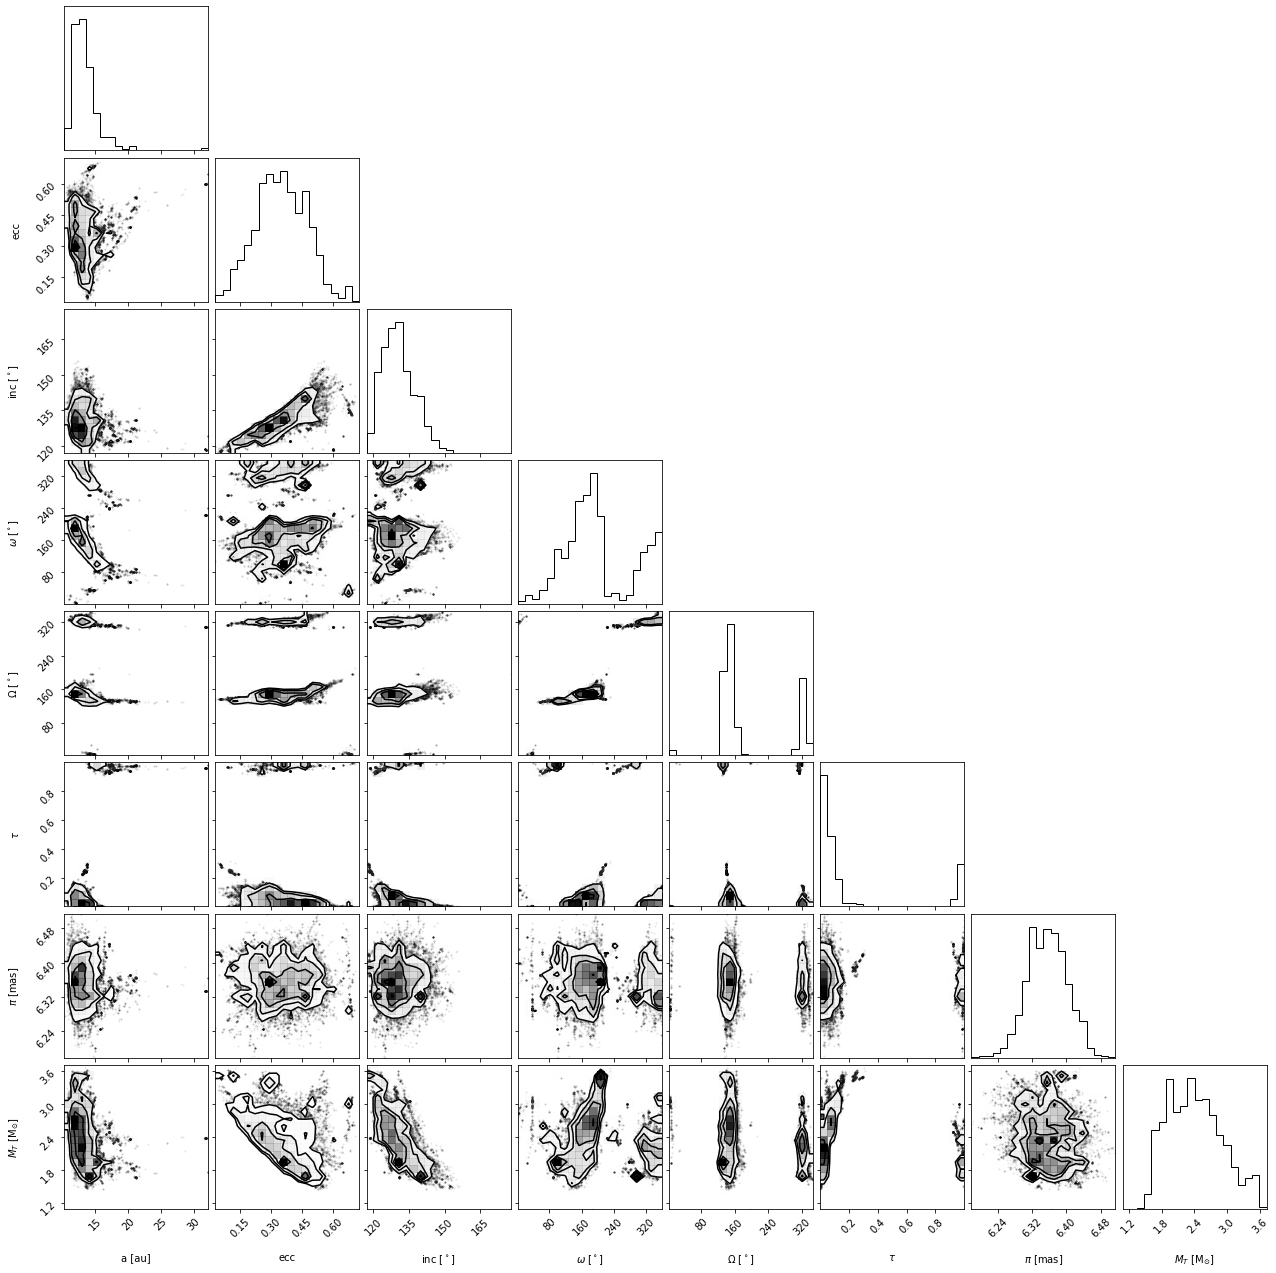

In [17]:
#MCMC PLOTS
corner_plot_fig = my_driver.sampler.results.plot_corner() # Creates a corner plot and returns Figure object
corner_plot_fig.savefig('hd142527Ball_corner_plot.png', transparent=True, dpi=300) # This is matplotlib.figure.Figure.savefig()

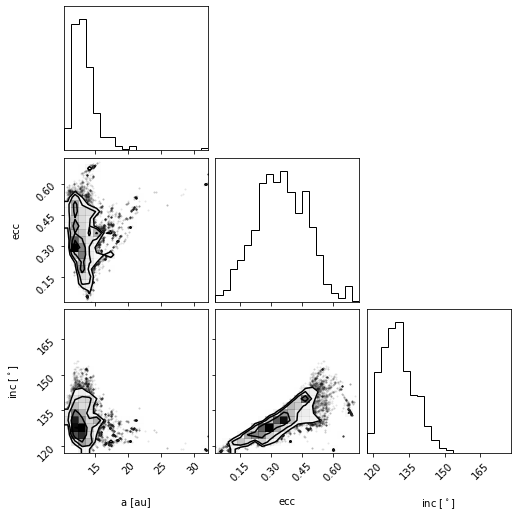

In [13]:
#MCMC PLOTS
corner_plot_fig = my_driver.sampler.results.plot_corner(param_list=['sma1','ecc1','inc1']) # Creates a corner plot and returns Figure object
corner_plot_fig.savefig('hd142527Ball_small_corner_plot.png', transparent=True, dpi=300) # This is matplotlib.figure.Figure.savefig()

In [14]:
epochs = my_driver.system.data_table['epoch']
epochs_yr = Time(epochs, format='mjd').decimalyear
# grab data from Driver object
data_tab = outtable
data_tab['yr'] = epochs_yr
data_tab['pa'][data_tab['pa'] < 180] += 360

insts = []
for inst in data_tab['inst']:
    if inst not in insts:
        insts.append(inst)
instdict = {}
for inst in insts:
    inds = []
    for i in data_tab.index:
        if inst == data_tab['inst'].iloc[i]:
            inds.append(i)
    print(inst, inds)
    instdict[inst] = data_tab.iloc[inds]

NACO [0, 1, 3]
VisAO [2, 4, 7, 8, 14]
GPI [5]
IFS/IRDIS [6, 9, 10, 11, 12, 13]


In [15]:
colors = ['xkcd:light pink', 'xkcd:dark purple', 'xkcd:sky blue', 'xkcd:lavender']

<Figure size 1008x432 with 0 Axes>

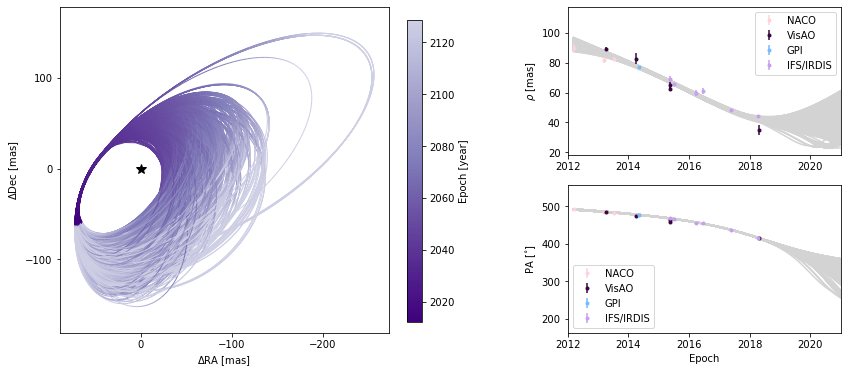

In [18]:
orb_fig = my_driver.sampler.results.plot_orbits(
    object_to_plot = 1, # Plot orbits for the first (and only, in this case) companion
    num_orbits_to_plot= 3200, # Will plot 100 randomly selected orbits of this companion
    start_mjd=epochs[0], # Minimum MJD for colorbar (here we choose first data epoch)
    plot_astrometry=False,
    data = my_driver.system.data_table,
    mod180=True
)

ax_orb, ax_sep, ax_pa, ax_cbar  = orb_fig.axes
c = 0
for inst in insts:
    data_tab = instdict[inst]
    color = colors[c]
    c += 1
    # add data to sep panel
    ax_sep.errorbar(
        data_tab['yr'], data_tab['sep'], data_tab['sep_err'],
        color=color, 
        linestyle='', fmt='o', zorder=3, label=inst, markersize=3
    )

    # add data to PA panel
    ax_pa.errorbar(
        data_tab['yr'], data_tab['pa'], data_tab['pa_err'],
        color=color, 
        linestyle='', fmt='o', zorder=3, label=inst, markersize=3
    )

ax_orb.plot(0,0,marker="*",color='black',markersize=10)
ax_sep.legend()
ax_pa.legend()

# zoom in a bit
ax_sep.set_xlim(2012,2021)
ax_pa.set_xlim(2012,2021)
# ax_sep.set_ylim(113.5,118)
# ax_pa.set_ylim(221,231)

plt.savefig('hd142527Ball_orbit_plot.png', transparent=True, dpi=150) # This is matplotlib.figure.Figure.savefig()

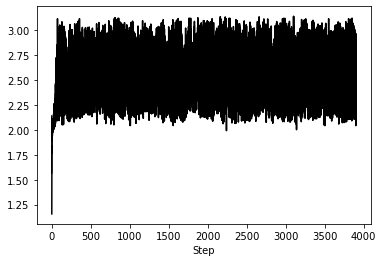

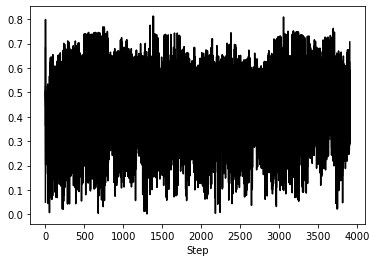

In [17]:
sma_chains, ecc_chains = my_driver.sampler.examine_chains(param_list=['inc1','ecc1'], n_walkers=5)plot_astrometry=

In [13]:
# save result as hdf5
hdf5_filename='my_posterior.hdf5'
import os
# To avoid weird behaviours, delete saved file if it already exists from a previous run of this notebook
if os.path.isfile(hdf5_filename):
    os.remove(hdf5_filename)
my_driver.sampler.results.save_results(hdf5_filename)

In [ ]:
# # save orbits result as csv
# import pandas as pd
# data = myResults.post
# df = pd.DataFrame(data, columns=myResults.labels)
# df.to_csv('test.csv')

In [2]:
# load in saved hdf5 result
hdf5_filename='my_posterior.hdf5'
from orbitize import results
loaded_results = results.Results() # Create blank results object for loading
loaded_results.load_results(hdf5_filename) 

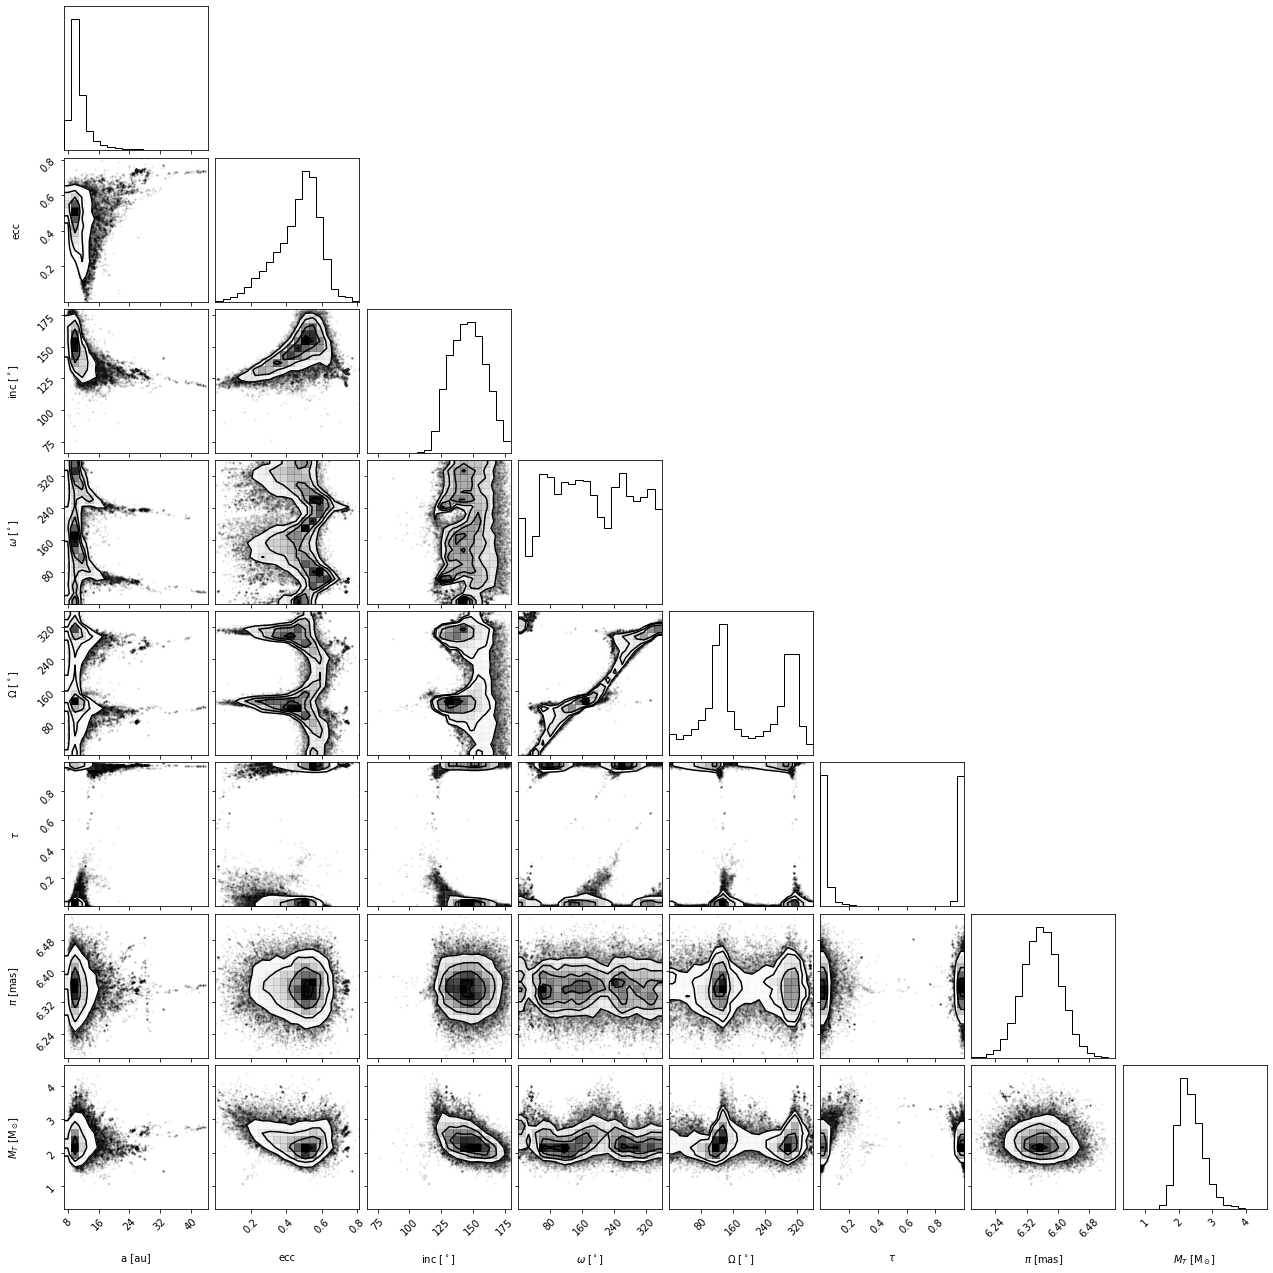

In [3]:
#MCMC PLOTS
corner_plot_fig = loaded_results.plot_corner() # Creates a corner plot and returns Figure object
corner_plot_fig.savefig('hd142527B_corner_plot.png', dpi=300) # This is matplotlib.figure.Figure.savefig()

<Figure size 1008x432 with 0 Axes>

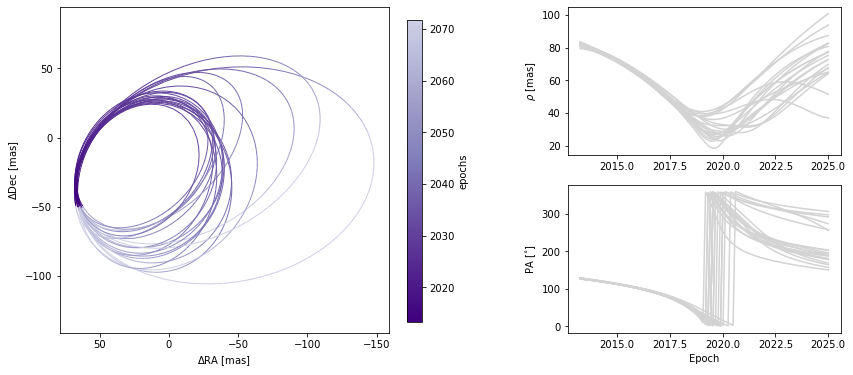

In [26]:
epochs = my_driver.system.data_table['epoch']

orbit_plot_fig = loaded_results.plot_orbits(
    object_to_plot = 1, # Plot orbits for the first (and only, in this case) companion
    num_orbits_to_plot= 20, # Will plot 100 randomly selected orbits of this companion
    start_mjd=epochs[0] # Minimum MJD for colorbar (here we choose first data epoch)
)
orbit_plot_fig.savefig('hd142527B_orbit_plot20.png', dpi=300) # This is matplotlib.figure.Figure.savefig()

In [22]:
# semimajor axis 1, eccentricity 1, inclination 1,
# argument of periastron 1, position angle of nodes 1,
# epoch of periastron passage 1,
incls = []
for i in range(len(loaded_results.post)):
    incl = loaded_results.post[i][1]
    incls.append(incl)

In [23]:
loaded_results.post

array([[9.86256412e+00, 3.15085538e-01, 1.33526195e+00, ...,
        1.64116169e-01, 6.38791255e+00, 1.84853164e+00],
       [8.29318960e+00, 4.18886790e-01, 1.64327190e+00, ...,
        8.55262700e-02, 6.37784969e+00, 2.01156672e+00],
       [1.45472080e+01, 1.61344412e-01, 1.71187326e+00, ...,
        2.10048122e-01, 6.31258931e+00, 1.50608063e+00],
       ...,
       [1.13045394e+01, 3.25658498e-01, 2.44228667e+00, ...,
        1.33249594e-02, 6.35169771e+00, 2.16927972e+00],
       [9.29093331e+00, 5.23772652e-01, 2.62565300e+00, ...,
        3.59251859e-02, 6.30630222e+00, 2.36200506e+00],
       [1.11616753e+01, 5.66424072e-01, 2.66272950e+00, ...,
        5.84032658e-03, 6.34190924e+00, 2.00973994e+00]])

In [24]:
import numpy as np
np.median(incls)

0.4860398690290588